# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

<Axes: xlabel='dteday'>

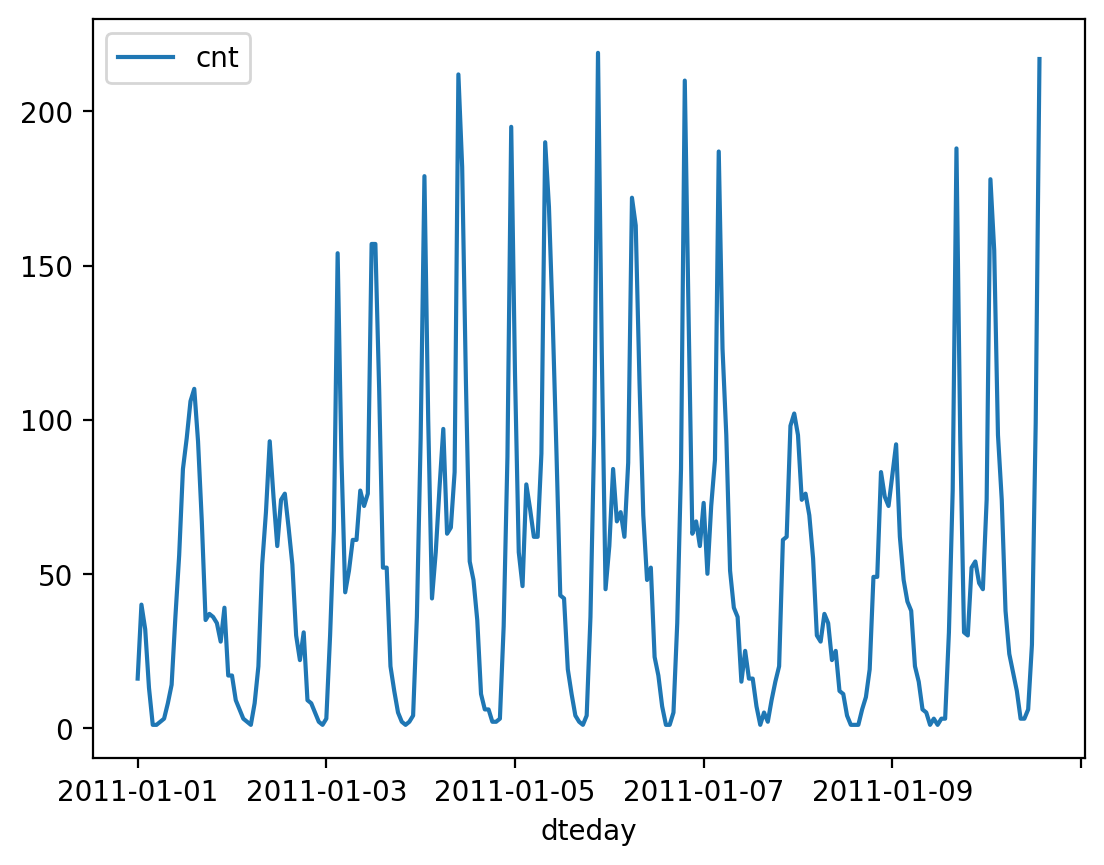

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,True,False,...,False,False,False,False,False,False,False,False,False,True
1,0,0,0.22,0.80,0.0,8,32,40,True,False,...,False,False,False,False,False,False,False,False,False,True
2,0,0,0.22,0.80,0.0,5,27,32,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0.24,0.75,0.0,3,10,13,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0,0,0.24,0.75,0.0,0,1,1,True,False,...,False,False,False,False,False,False,False,False,False,True


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
last21 = -21 * 24
print('last21:', last21) 

last21: -504


In [8]:
# Save data for approximately the last 21 days
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data
#  into features and targets
# Separate the data into features and targets
target_field = 'cnt'
# drop casual and registered
# Separate the data into features and targets
# Separate the data into features and targets
fields_to_drop = ['casual', 'registered', 'cnt']
features = data.drop(fields_to_drop, axis=1)
targets = data[['cnt']]  # Creates a DataFrame with a single column 'cnt'

test_features = test_data.drop(fields_to_drop, axis=1)
test_targets = test_data[['cnt']]  # Same for test data


'''
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
'''

"\ntarget_fields = ['cnt', 'casual', 'registered']\nfeatures, targets = data.drop(target_fields, axis=1), data[target_fields]\ntest_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]\n"

In [9]:
# check the shape of features and targets for both training and test sets
print('features.shape:', features.shape, 'targets.shape:', targets.shape)
print('test_features.shape:', test_features.shape, 'test_targets.shape:', test_targets.shape)

# print the head of features and targets for both training and test sets
#print('features.head():\n', features.head())
#print('targets.head():\n', targets.head())
#print('test_features.head():\n', test_features.head())
#print('test_targets.head():\n', test_targets.head())

# print col names for all data sets
print('features.columns:\n', features.columns)
print('targets.columns:\n', targets.columns)
print('test_features.columns:\n', test_features.columns)
print('test_targets.columns:\n', test_targets.columns)




features.shape: (16875, 56) targets.shape: (16875, 1)
test_features.shape: (504, 56) test_targets.shape: (504, 1)
features.columns:
 Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_1', 'season_2',
       'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8',
       'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16',
       'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6'],
      dtype='object')
targets.columns:
 Index(['cnt'], dtype='object')
test_features.columns:
 Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_1', 'season_2',
       'season_3', 'season_4', 'weathersit_1', 'weather

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [10]:
# print col names for all data sets
print('features.columns:\n', features.columns)
print('targets.columns:\n', targets.columns)
print('test_features.columns:\n', test_features.columns)
print('test_targets.columns:\n', test_targets.columns)

# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

features.columns:
 Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_1', 'season_2',
       'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8',
       'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16',
       'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6'],
      dtype='object')
targets.columns:
 Index(['cnt'], dtype='object')
test_features.columns:
 Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_1', 'season_2',
       'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [11]:
import numpy as np
import pandas as pd
import os


class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
    
    def save_weights(self, filename):
        ''' Save the weights of the neural network to a file. '''
        weights = {
            'input_to_hidden': self.weights_input_to_hidden,
            'hidden_to_output': self.weights_hidden_to_output
        }
        np.savez(filename, **weights)
    
    def load_latest_weights(self, directory='saved_weights'):
        """ Load the latest weights from the specified directory. """
        if not os.path.exists(directory) or not os.listdir(directory):
            print("Directory not found or is empty. No weights loaded.")
            return

        # List all .npz files in the directory
        files = [f for f in os.listdir(directory) if f.endswith('.npz') and f.startswith('weights_iter_')]
        
        # Extract the iteration numbers from the file names
        iter_numbers = [int(f.split('_')[-1].split('.')[0]) for f in files]

        # Find the file with the highest iteration number
        latest_file = files[np.argmax(iter_numbers)]
        latest_path = os.path.join(directory, latest_file)
        
        # Load weights from this file
        data = np.load(latest_path)
        self.weights_input_to_hidden = data['input_to_hidden']
        self.weights_hidden_to_output = data['hidden_to_output']
        print(f"Loaded weights from {latest_path}")
                    

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implement the forward pass function below
            # Implement the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implement forward pass here 
         
            Arguments
            ---------
            X: features batch

        '''
        #print("X shape, X dtype: ", X.shape, X.dtype)
        if X.dtype == 'O':
            X = X.astype('float64')

        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer - Replace these values with your calculations.
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        # Convert all inputs to float64 if they are not already
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        
        # Calculate the output error - Output layer error is the difference between desired target and actual output.
        error = y - final_outputs
        
        # Calculate the output error term - For regression, this is just the error as the derivative of the activation function is 1.
        output_error_term = error
        
        # Calculate the hidden layer's contribution to the error - This is the error propagated to the hidden layer.
        hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
        
        # Calculate the hidden layer error term - This is the error of the hidden layer scaled by the derivative of the activation function (sigmoid in this case).
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Reshape X to ensure it's a 2D array for the weight update step
        X = X.reshape(-1, self.input_nodes)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X.T
        
        # Weight step (hidden to output) - hidden_outputs needs to be a 2D array
        hidden_outputs = hidden_outputs.reshape(-1, self.hidden_nodes)
        delta_weights_h_o += output_error_term * hidden_outputs.T

        return delta_weights_i_h, delta_weights_h_o
    
    
    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: DataFrame or 2D array where each row is one data record, each column is a feature
        '''
        
        # Convert DataFrame to NumPy array if it's a DataFrame
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()

        # Ensure features is a 2D array
        if features.ndim == 1:
            features = features.reshape(1, -1)  # Reshape 1D array to 2D array with one row
        elif features.ndim > 2:
            raise ValueError("Features must be a 1D or 2D array.")

        # Convert to float64 if not already
        if features.dtype != np.float64:
            features = features.astype(np.float64)

        # Hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)  # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)  # signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)  # signals into final output layer
        final_outputs = final_inputs  # For regression, output is linear
        
        return final_outputs


In [12]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

#from my_answers import NeuralNetwork

In [13]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [14]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [15]:
#########################################################
# Set your hyperparameters here
##########################################################
iterations = 10000
learning_rate = 0.01
hidden_nodes = 32
output_nodes = 1

In [16]:
import sys
import os

# Import hyperparameters
#from my_answers import iterations, learning_rate, hidden_nodes, output_nodes

# Initialize the network
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)
network.load_latest_weights()

Loaded weights from saved_weights/weights_iter_9500.npz


In [17]:


# Initialize dictionary to store loss values
losses = {'train':[], 'validation':[]}

# Early stopping parameters
early_stopping = True
patience = 100  # Increased patience
min_loss_threshold = 0.3  # Threshold for acceptable loss
start_early_stopping_at_iter = 500  # Start checking early stopping after this many iterations
best_val_loss = float('inf')
patience_counter = 0

save_weights_period = 500
# Create a directory for saving weights if it doesn't exist
weights_dir = 'saved_weights'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

for ii in range(iterations):
    # Select a random batch of records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
    
    # Perform training on the batch
    network.train(X, y)
    
    # Evaluate the model on the entire training set
    train_predictions = network.run(train_features)
    train_loss = MSE(train_predictions.T, train_targets['cnt'].values)
    
    # Evaluate the model on the entire validation set
    val_predictions = network.run(val_features)
    val_loss = MSE(val_predictions.T, val_targets['cnt'].values)
    
    # Print out the training progress
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    # Store the losses for plotting or analysis
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

    # Save weights periodically
    if ii % save_weights_period == 0:
        filename = os.path.join(weights_dir, f'weights_iter_{ii}.npz')
        network.save_weights(filename)

    # Early stopping checks
    if early_stopping and ii > start_early_stopping_at_iter:
        if train_loss < min_loss_threshold and val_loss < min_loss_threshold:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                filename = os.path.join(weights_dir, 'weights_early_stopping.npz')
                network.save_weights(filename)
                print("\nEarly stopping triggered at iteration %d" % ii)
                break


Progress: 100.0% ... Training loss: 0.288 ... Validation loss: 0.454

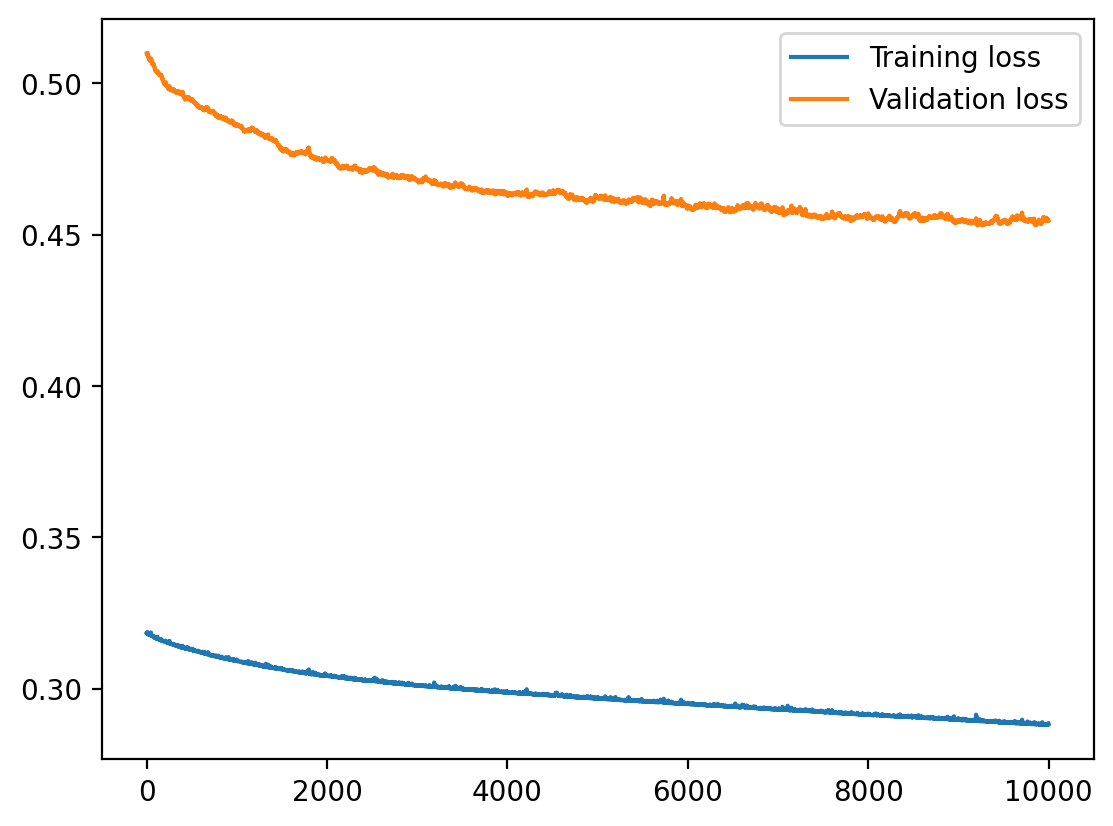

In [18]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

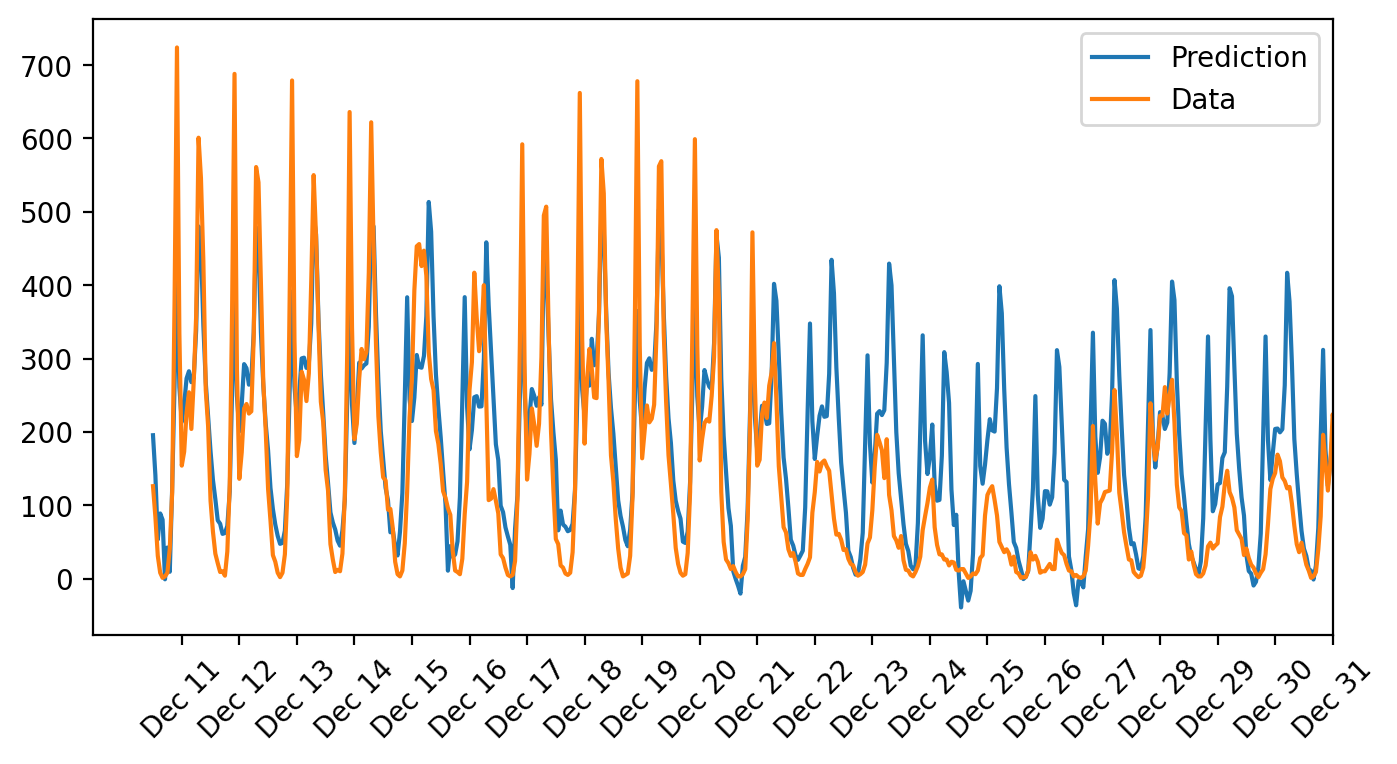

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

## Submitting:
Open up the 'jwt' file in the first-neural-network directory (which also contains this notebook) for submission instructions

# try using Keras for better results

In [20]:
# print col names for all data sets
#print('features.columns:\n', features.columns)
#print('targets.columns:\n', targets.columns)
#print('test_features.columns:\n', test_features.columns)
#print('test_targets.columns:\n', test_targets.columns)

# Hold out the last 60 days or so of the remaining data as a validation set
#train_features, train_targets = features[:-60*24], targets[:-60*24]
#val_features, val_targets = features[-60*24:], targets[-60*24:]

# print out dtypes of the above data sets
print('train_features.dtypes:\n', train_features.dtypes)
print('train_targets.dtypes:\n', train_targets.dtypes)
print('val_features.dtypes:\n', val_features.dtypes)
print('val_targets.dtypes:\n', val_targets.dtypes)

# check if they above datasets are valid inputs for Keras model
print('train_features.shape:', train_features.shape, 'train_targets.shape:', train_targets.shape)
print('val_features.shape:', val_features.shape, 'val_targets.shape:', val_targets.shape)

# check if above datasets are all numpy arrays
print('train_features type:', type(train_features))
print('train_targets type:', type(train_targets))
print('val_features type:', type(val_features))
print('val_targets type:', type(val_targets))


train_features.dtypes:
 yr                int64
holiday           int64
temp            float64
hum             float64
windspeed       float64
season_1           bool
season_2           bool
season_3           bool
season_4           bool
weathersit_1       bool
weathersit_2       bool
weathersit_3       bool
weathersit_4       bool
mnth_1             bool
mnth_2             bool
mnth_3             bool
mnth_4             bool
mnth_5             bool
mnth_6             bool
mnth_7             bool
mnth_8             bool
mnth_9             bool
mnth_10            bool
mnth_11            bool
mnth_12            bool
hr_0               bool
hr_1               bool
hr_2               bool
hr_3               bool
hr_4               bool
hr_5               bool
hr_6               bool
hr_7               bool
hr_8               bool
hr_9               bool
hr_10              bool
hr_11              bool
hr_12              bool
hr_13              bool
hr_14              bool
hr_15           

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


float32 = "float32"
# Create the model
model = Sequential()
model.add(Dense(64, input_dim=train_features.shape[1], activation='relu')) # Adding a hidden layer
model.add(Dense(1, activation='linear'))

adam_optimizer = Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Train the model
#model.fit(train_features.to_numpy().astype(float32), train_targets.to_numpy().astype(float32), epochs=10, batch_size=32)

# Evaluate the model
#loss = model.evaluate(val_features.to_numpy().astype(float32), val_targets.to_numpy().astype(float32))
#print('Test loss:', loss)

2023-12-02 14:54:14.969057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 14:54:14.969149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 14:54:14.970361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 14:54:14.975742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 14:54:16.029258: W tensorflow/compiler/tf2

In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


Epoch 1/100
483/483 [==============================] - 1s 1ms/step - loss: 0.3556 - val_loss: 0.3960
Epoch 2/100
483/483 [==============================] - 0s 789us/step - loss: 0.1735 - val_loss: 0.2653
Epoch 3/100
483/483 [==============================] - 0s 855us/step - loss: 0.1017 - val_loss: 0.1779
Epoch 4/100
483/483 [==============================] - 0s 841us/step - loss: 0.0761 - val_loss: 0.1556
Epoch 5/100
483/483 [==============================] - 0s 784us/step - loss: 0.0663 - val_loss: 0.1420
Epoch 6/100
483/483 [==============================] - 0s 847us/step - loss: 0.0602 - val_loss: 0.1393
Epoch 7/100
483/483 [==============================] - 0s 768us/step - loss: 0.0557 - val_loss: 0.1366
Epoch 8/100
483/483 [==============================] - 0s 803us/step - loss: 0.0529 - val_loss: 0.1319
Epoch 9/100
483/483 [==============================] - 0s 774us/step - loss: 0.0503 - val_loss: 0.1268
Epoch 10/100
483/483 [==============================] - 0s 817us/step - los

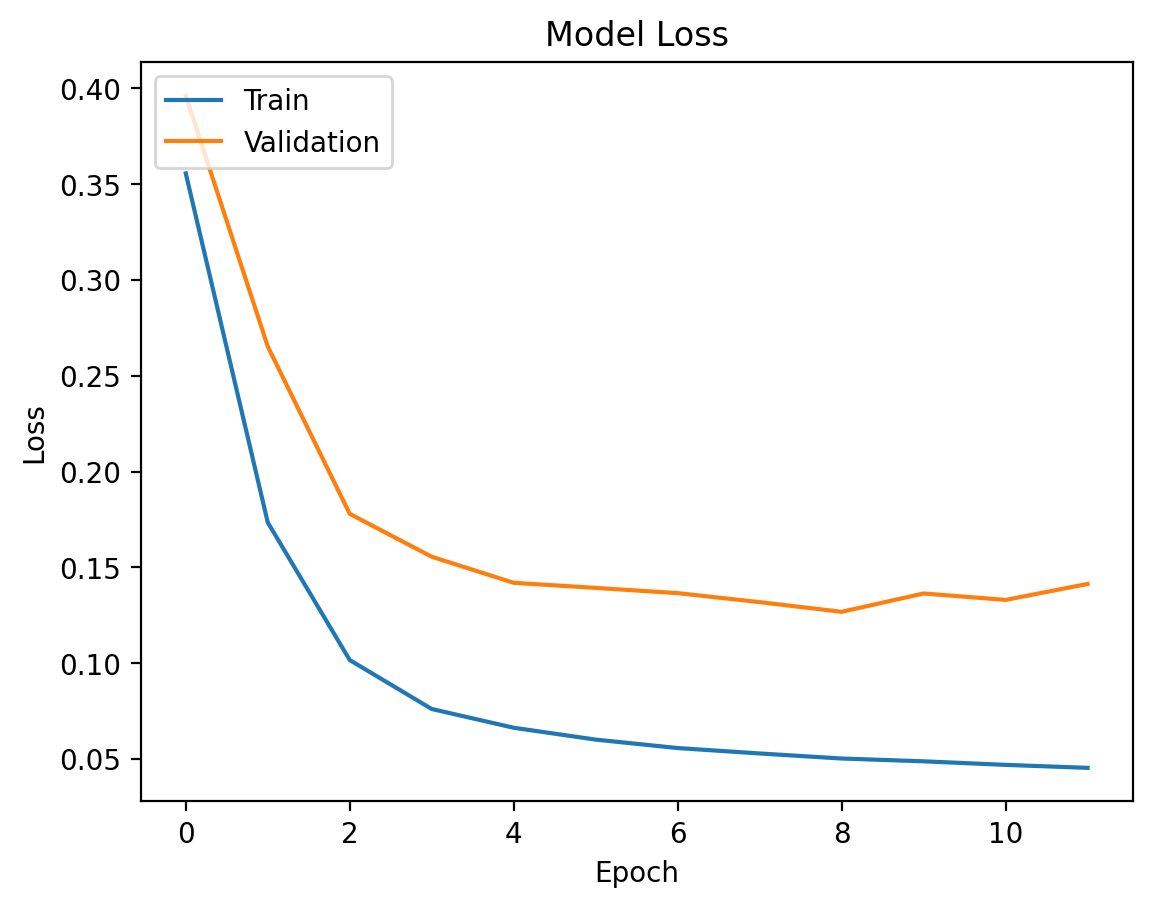

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with validation split
history = model.fit(
    train_features.to_numpy().astype(float32), 
    train_targets.to_numpy().astype(float32),
    epochs=100,
    batch_size=32,
    validation_data=(val_features.to_numpy().astype('float32'), val_targets.to_numpy().astype('float32')),
    callbacks=[early_stopping]
)

# Evaluate the model
loss = model.evaluate(test_features.to_numpy().astype(float32), test_targets.to_numpy().astype(float32))
print('Test loss:', loss)

# Optionally, plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

16/16 [==============================] - 0s 805us/step


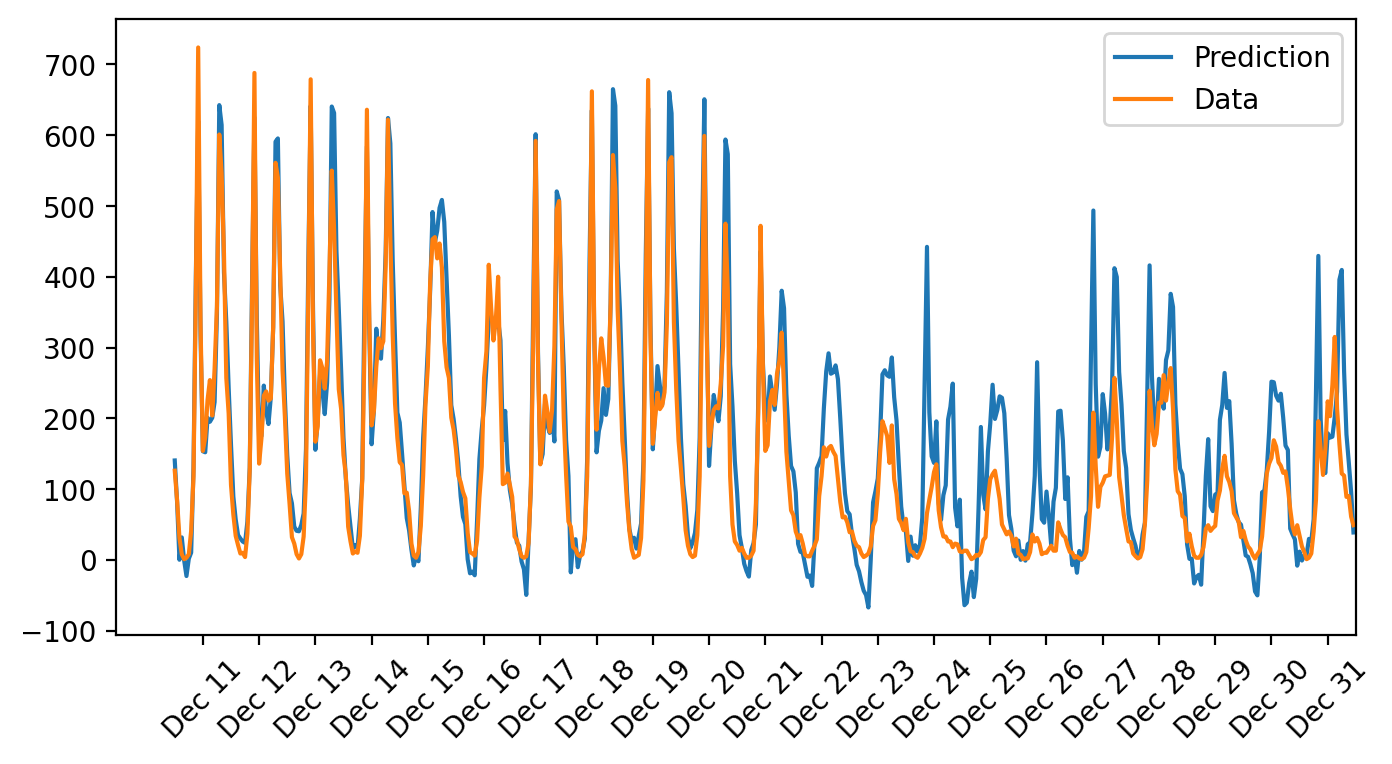

In [24]:
# Ensure that test_features is a NumPy array with the correct data type
test_features_array = test_features.to_numpy().astype('float32')

# Get predictions
predictions_scaled = model.predict(test_features_array)

# Rescale predictions back to original distribution
mean = scaled_features['cnt'][0]
std = scaled_features['cnt'][1]
predictions = predictions_scaled * std + mean

# Convert predictions and actual values to their original scale
actual = (test_targets['cnt']*std + mean).values

# Now you can proceed to plot or save the predictions as needed


# Assuming you have already defined `predictions` and `actual` as numpy arrays

# Plotting
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(predictions, label='Prediction')
ax.plot(actual, label='Data')  # No need to index 'cnt' as `actual` is a numpy array
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

plt.show()


In [27]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.15.0
Is GPU available: False
Num GPUs Available:  0


In [26]:
#! pip uninstall tensorflow
#! pip install tensorflow-gpu==2.15.0


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/estimator_ckpt_converter
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/import_pb_to_tensorboard
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/saved_model_cli
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/tensorboard
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/tf_upgrade_v2
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/tflite_convert
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/toco
    /home/nyck33/miniforge-pypy3/envs/streamlit/bin/toco_from_protos
    /home/nyck33/miniforge-pypy3/envs/streamlit/lib/python3.10/site-packages/tensorflow-2.15.0.dist-info/*
    /home/nyck33/miniforge-pypy3/envs/streamlit/lib/python3.10/site-packages/tensorflow/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.15.0 (from versions: 2.8.0rc0